<a href="https://colab.research.google.com/github/AnshChoudhary/Autonomous-Driving/blob/main/U_net_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: unzip a file from google drive that is mounted

import zipfile

# Get the path to the zip file in your Google Drive.
zip_path = '/content/drive/MyDrive/training.zip'

# Extract the contents of the zip file.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('/content/TuSimple')


In [3]:
!pip install tensorflow numpy opencv-python matplotlib

# Code that trains on the entire TuSimple Dataset:
(Session crashes on Colab due to insufficient RAM)

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_tusimple_dataset(image_dir, mask_dir, img_size=(256,256)):
  images = []
  masks = []
  image_filenames = sorted(os.listdir(image_dir))
  mask_filenames = sorted(os.listdir(mask_dir))

  for img_name, mask_name in zip(image_filenames, mask_filenames):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)

    image = cv2.imread(img_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    images.append(image)
    masks.append(mask)

  return np.array(images), np.array(masks)

image_dir = '/content/TuSimple/kaggle/working/tusimple_preprocessed/training/frames'
mask_dir = '/content/TuSimple/kaggle/working/tusimple_preprocessed/training/lane-masks'

# Load the dataset
images, masks = load_tusimple_dataset(image_dir, mask_dir)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Code that trains on a subset of the TuSimple Dataset:


In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_tusimple_subset_dataset(image_dir, mask_dir, img_size=(256, 256), subset_size=None):
    images = []
    masks = []
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    # Randomly sample a subset if subset_size is specified
    if subset_size:
        indices = np.random.choice(len(image_filenames), subset_size, replace=False)
        image_filenames = [image_filenames[i] for i in indices]
        mask_filenames = [mask_filenames[i] for i in indices]

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        image = image / 255.0  # Normalize the image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize the mask
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Define paths to the KITTI images and masks
image_dir = '/content/TuSimple/kaggle/working/tusimple_preprocessed/training/frames'
mask_dir = '/content/TuSimple/kaggle/working/tusimple_preprocessed/training/lane-masks'

# Define subset size to fit within memory limits
subset_size = 1000

# Load the datasets
images, masks = load_tusimple_subset_dataset(image_dir, mask_dir, subset_size=subset_size)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

print(get_available_devices())



['/device:CPU:0', '/device:GPU:0']


In [6]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
  # Now your code will run on the GPU
  import tensorflow as tf
  from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
  from tensorflow.keras.models import Model
  from tensorflow.keras.layers import Input

  def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    #Encoder
    conv1 = Conv2D(64,(3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3,3), activation ='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

    conv2 = Conv2D(128,(3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3,3), activation ='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

    conv3 = Conv2D(256,(3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3,3), activation ='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

    conv4 = Conv2D(512,(3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3,3), activation ='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

    conv5 = Conv2D(1024,(3,3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3,3), activation ='relu', padding='same')(conv5)

    #Decoder
    up6 = UpSampling2D(size=(2,2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2,2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2,2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, (3,3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3,3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2,2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

  model = unet_model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=50, batch_size=16)

  model.save('unet_lane_detection_tusimple.h5')

Epoch 1/50
50/50 [==============================] - 94s 951ms/step - loss: 0.9713 - accuracy: 0.9444 - val_loss: 0.1727 - val_accuracy: 0.9439
Epoch 2/50
50/50 [==============================] - 39s 785ms/step - loss: 0.1603 - accuracy: 0.9445 - val_loss: 0.1474 - val_accuracy: 0.9439
Epoch 3/50
50/50 [==============================] - 39s 782ms/step - loss: 0.1494 - accuracy: 0.9445 - val_loss: 0.1480 - val_accuracy: 0.9439
Epoch 4/50
50/50 [==============================] - 42s 833ms/step - loss: 0.1373 - accuracy: 0.9445 - val_loss: 0.1307 - val_accuracy: 0.9439
Epoch 5/50
50/50 [==============================] - 41s 831ms/step - loss: 0.1172 - accuracy: 0.9458 - val_loss: 0.1055 - val_accuracy: 0.9470
Epoch 6/50
50/50 [==============================] - 42s 834ms/step - loss: 0.0945 - accuracy: 0.9485 - val_loss: 0.0931 - val_accuracy: 0.9479
Epoch 7/50
50/50 [==============================] - 42s 834ms/step - loss: 0.0777 - accuracy: 0.9523 - val_loss: 0.0741 - val_accuracy: 0.9521

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 24s 443ms/step - loss: 0.1146 - accuracy: 0.9590
Validation Loss: 0.11461285501718521
Validation Accuracy: 0.9590102434158325
1/1 [==============================] - 2s 2s/step


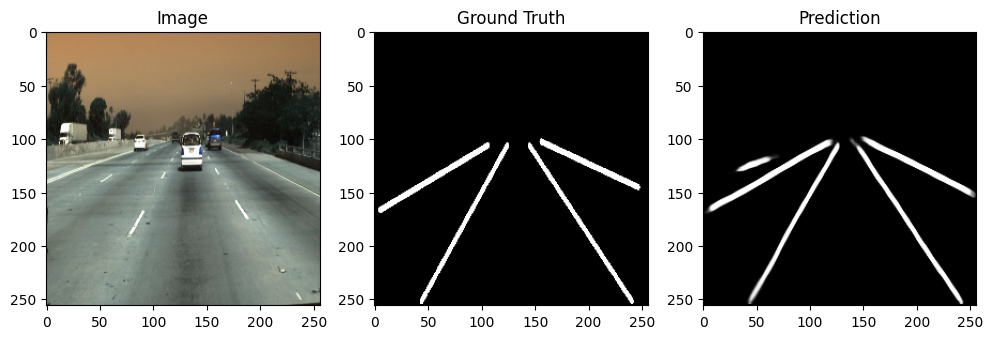

1/1 [==============================] - 0s 36ms/step


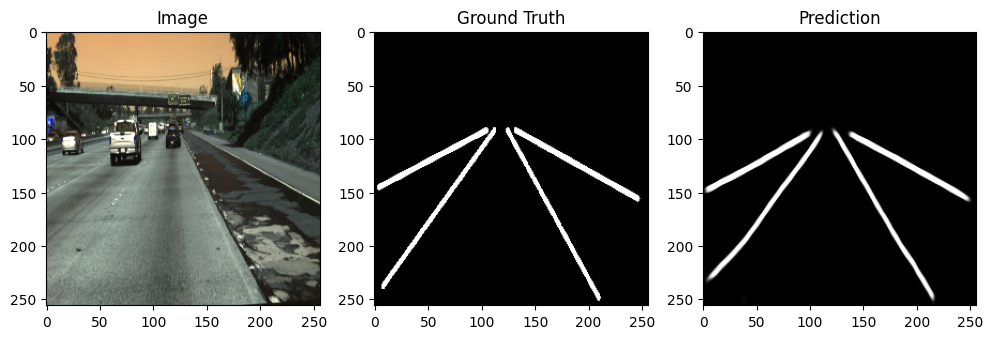

1/1 [==============================] - 0s 19ms/step


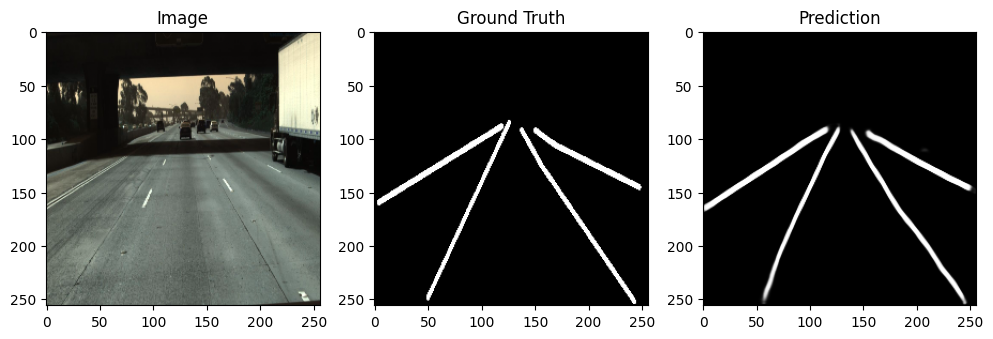

1/1 [==============================] - 0s 20ms/step


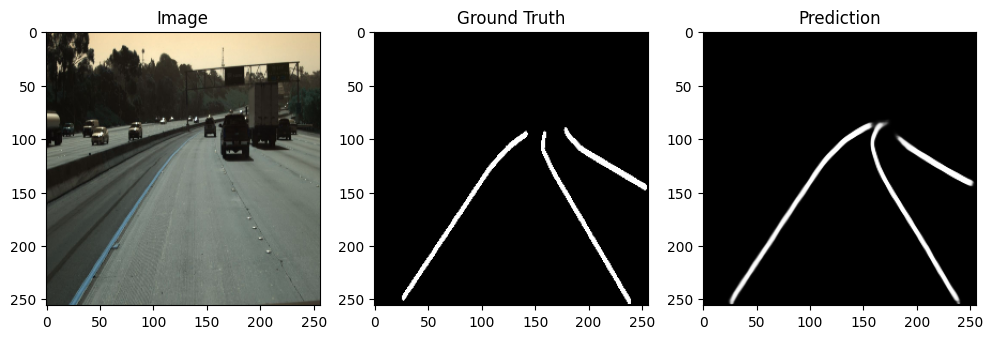

1/1 [==============================] - 0s 19ms/step


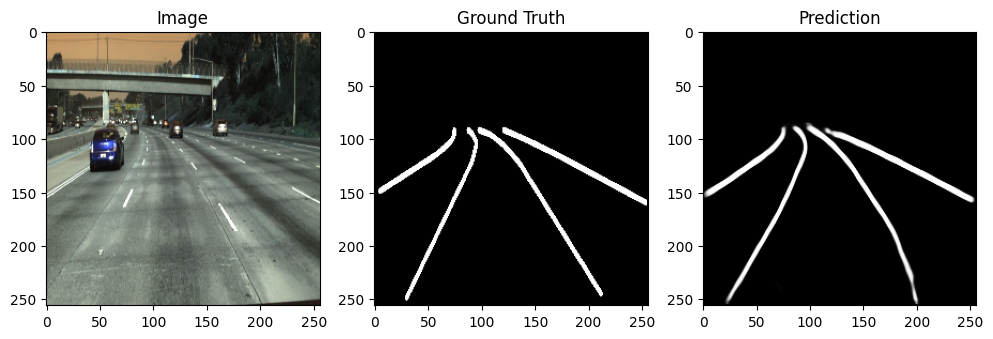

In [9]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('unet_lane_detection_tusimple.h5')

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Function to visualize predictions
def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Prediction')

    plt.show()

# Predict and visualize some samples from the validation set
for i in range(5):
    sample_image = x_val[i]
    sample_mask = y_val[i]
    sample_prediction = model.predict(np.expand_dims(sample_image, axis=0))[0]
    plot_sample(sample_image, sample_mask, sample_prediction)


# Running Inference on the trained model

Saving 0313-1_23940.jpg to 0313-1_23940 (3).jpg


1/1 [==============================] - 0s 197ms/step


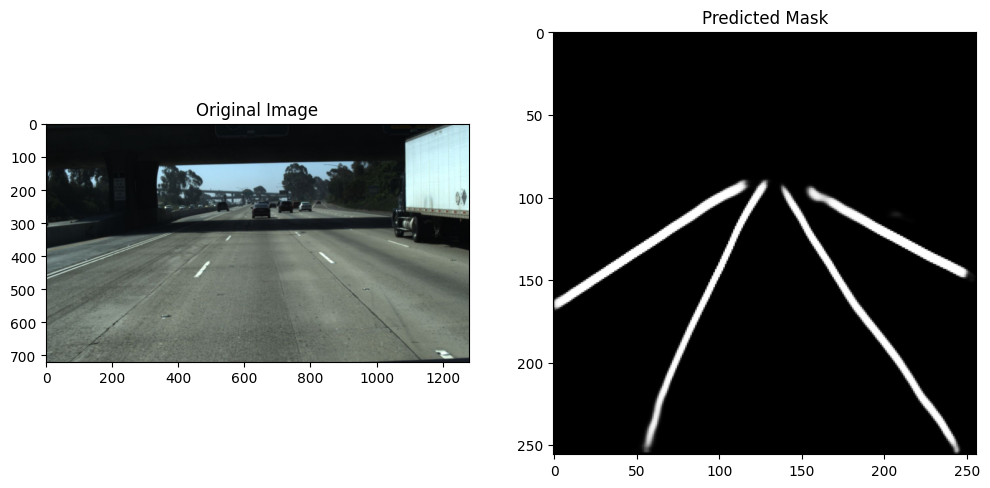

In [14]:
from tensorflow.keras.models import load_model
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('unet_lane_detection_tusimple.h5')

# Function to upload and preprocess an image
def upload_and_preprocess_image(img_size=(256, 256)):
    uploaded = files.upload()
    for file_name in uploaded.keys():
        # Read the image
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, img_size)
        img_normalized = img_resized / 255.0  # Normalize the image
        return img, img_normalized.reshape((1, img_size[0], img_size[1], 3))

# Call the function to upload an image
original_img, preprocessed_img = upload_and_preprocess_image()

# Run inference
predicted_mask = model.predict(preprocessed_img)[0]

# Function to visualize the original image and the predicted mask
def plot_inference_results(original_img, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Plot the results
plot_inference_results(original_img, predicted_mask)

Saving 0313-1_23940.jpg to 0313-1_23940 (4).jpg
1/1 [==============================] - 0s 218ms/step


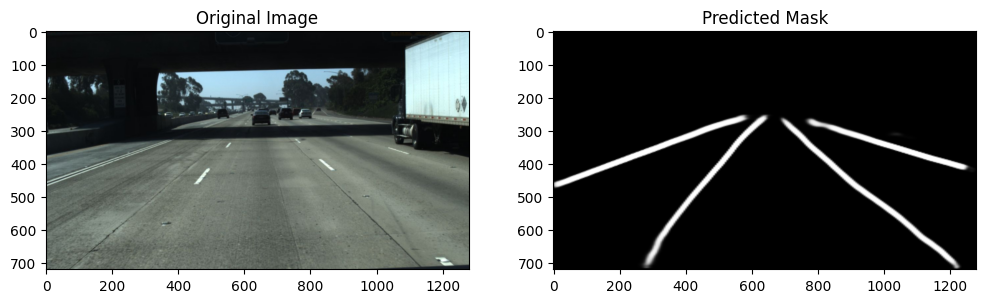

In [15]:
from tensorflow.keras.models import load_model
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('unet_lane_detection_tusimple.h5')

# Function to upload and preprocess an image
def upload_and_preprocess_image(img_size=(256, 256)):
    uploaded = files.upload()
    for file_name in uploaded.keys():
        # Read the image
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # Store the original size
        img_resized = cv2.resize(img, img_size)
        img_normalized = img_resized / 255.0  # Normalize the image
        return img, img_normalized.reshape((1, img_size[0], img_size[1], 3)), original_size

# Call the function to upload an image
original_img, preprocessed_img, original_size = upload_and_preprocess_image()

# Run inference
predicted_mask = model.predict(preprocessed_img)[0]

# Resize the predicted mask to match the original image size
predicted_mask_resized = cv2.resize(predicted_mask, (original_size[1], original_size[0]))

# Function to visualize the original image and the predicted mask
def plot_inference_results(original_img, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Plot the results
plot_inference_results(original_img, predicted_mask_resized)


Saving 0313-1_23940.jpg to 0313-1_23940 (5).jpg
1/1 [==============================] - 0s 210ms/step


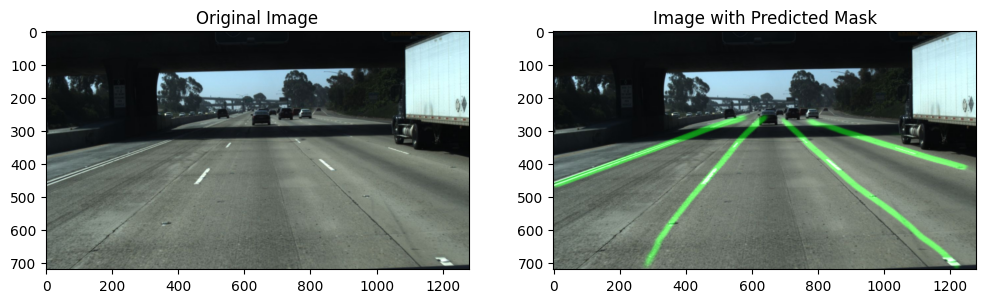

In [16]:
from tensorflow.keras.models import load_model
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('unet_lane_detection_tusimple.h5')

# Function to upload and preprocess an image
def upload_and_preprocess_image(img_size=(256, 256)):
    uploaded = files.upload()
    for file_name in uploaded.keys():
        # Read the image
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # Store the original size
        img_resized = cv2.resize(img, img_size)
        img_normalized = img_resized / 255.0  # Normalize the image
        return img, img_normalized.reshape((1, img_size[0], img_size[1], 3)), original_size

# Call the function to upload an image
original_img, preprocessed_img, original_size = upload_and_preprocess_image()

# Run inference
predicted_mask = model.predict(preprocessed_img)[0]

# Resize the predicted mask to match the original image size
predicted_mask_resized = cv2.resize(predicted_mask, (original_size[1], original_size[0]))

# Function to visualize the original image with the predicted mask applied
def plot_inference_results(original_img, prediction):
    # Create an overlay with the mask
    mask_green = np.zeros_like(original_img)
    mask_green[:, :, 1] = (prediction * 255).astype(np.uint8)  # Set green channel

    # Convert the mask to an RGBA image
    mask_rgba = cv2.cvtColor(mask_green, cv2.COLOR_RGB2RGBA)
    mask_rgba[:, :, 3] = (prediction * 255).astype(np.uint8)  # Set alpha channel

    # Convert the original image to RGBA
    original_img_rgba = cv2.cvtColor(original_img, cv2.COLOR_RGB2RGBA)

    # Overlay the mask on the original image
    overlaid_img = cv2.addWeighted(original_img_rgba, 1, mask_rgba, 0.5, 0)

    # Plot the original image and the overlaid image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(overlaid_img)
    plt.title('Image with Predicted Mask')

    plt.show()

# Plot the results
plot_inference_results(original_img, predicted_mask_resized)